In [1]:
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import astropy.units as u
import splat.empirical as spe
import splat
#plt.style.use('dark_background')

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




Purpose: compare various luminosity functions

In [2]:
%matplotlib inline

In [3]:
import popsims

In [4]:
baraffe=popsims.make_systems(model_name='baraffe2003', 
                             bfraction=0.2, nsample=int(1e5), mass_age_range=[0.01, 0.2, 0., 8.0])
saumon=popsims.make_systems(model_name='saumon2008', bfraction=0.2, nsample=int(1e5)
                            , mass_age_range=[0.01, 0.2, 0.1, 8.0])
sonora=popsims.make_systems(model_name='marley2019', bfraction=0.2, nsample=int(1e5)
                            , mass_age_range=[0.01, 0.2, 0.1, 8.0])
phillips=popsims.make_systems(model_name='phillips2020', bfraction=0.2, nsample=int(1e5)
                              , mass_age_range=[0.01, 0.2, 0.1, 8.0])
burrows=popsims.make_systems(model_name='burrows2001', bfraction=0.2, nsample=int(1e5)
                             , mass_age_range=[0.01, 0.2, 0.1, 8.0])
burrows97=popsims.make_systems(model_name='burrows1997', bfraction=0.2, nsample=int(1e5),
                               mass_age_range=[0.01, 0.2, 0.1, 8.0])

In [5]:
from astropy.io import ascii

In [6]:
klf=pd.read_csv('/volumes/Lacie/wispsdata/data/kirkpatricklf.txt', delimiter=',')
dntb=ascii.read('/volumes/Lacie/wispsdata/data/daniellalf.txt').to_pandas()

In [7]:
def splat_mag_to_spt(mag):
    grid=np.arange(17, 39)
    rel=spe.typeToMag(grid, 'MKO_J',reference='dupuy2012')[0]
    vals= np.polyval(rel, grid)
    spt_sorted_idx=np.argsort(vals)
    return np.interp(mag, vals[spt_sorted_idx], grid[spt_sorted_idx])
       

In [8]:
klf['tfm']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)

In [9]:
klf['spt']=klf.tfm.apply(wispsim.splat_teff_to_spt).apply(round)

In [10]:
klf=klf.applymap(float)

In [11]:
dntb['spt']=dntb.M_J.apply(splat_mag_to_spt)

In [12]:
def ryan_lf(J):
    logphi=-0.30 + 0.11*(J-14) + 0.15*(J -14)**2.+ 0.015*(J-14)**3-0.00020*(J-14)**4
    return (10**logphi)*(10**-3)

    
def custom_histogram(things, grid, binsize):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+binsize)]))
    return np.array(n)

In [13]:
jgrid=np.arange(10, 18, .5)
teffgrid=np.arange(50, 4000, 150)

In [14]:
#the last point is a lower limit
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [15]:
1950+150

2100

In [16]:
binedges= np.append(kirkpatrick2020LF['bin_center']-75,
                    kirkpatrick2020LF['bin_center'][-1]+75)
                    
binedges

array([ 450,  600,  750,  900, 1050, 1200, 1350, 1500, 1650, 1800, 1950,
       2100])

In [17]:
kirkpatrick2020LF

{'bin_center': array([ 525,  675,  825,  975, 1125, 1275, 1425, 1575, 1725, 1875, 2025]),
 'values': array([4.24, 2.8 , 1.99, 1.72, 1.11, 1.95, 0.94, 0.81, 0.78, 0.5 , 0.72]),
 'unc': array([0.7 , 0.37, 0.32, 0.3 , 0.25, 0.3 , 0.22, 0.2 , 0.2 , 0.17, 0.18])}

In [18]:
def scale_lf_teff(teffs):
    binedges= np.append(kirkpatrick2020LF['bin_center']-75, kirkpatrick2020LF['bin_center'][-1]+75)
    #bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    #print (binedges[0], binedges[-1])
    preds=np.histogram(teffs, bins=binedges, normed=False)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
    
    
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    res=preds*np.nanmedian(scale), [np.nanmedian(scale), np.nanstd(scale), \
                                     np.sum(preds*np.nanmedian(scale))]
    #fig, ax=plt.subplots()
    #ax.step(kirkpatrick2020LF['bin_centertw'], preds*scale*(10**-3), where='mid')
    #ax.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
    #         yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3), fmt='o', color='#111111')
    return res

In [19]:
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

In [20]:
teffs_bar=baraffe['temperature']
teffs_saumon=saumon['temperature']
teffs_sonora=sonora['temperature']
teffs_phil=phillips['temperature']
teffs_burr=burrows['temperature']
teffs_burr97=burrows97['temperature']

#normteff_bar = 0.63*(10**-3)/ len(teffs_bar[np.logical_and(teffs_bar>=1650, teffs_bar <=1800)])
#normteff_saumon = 0.63*(10**-3)/ len(teffs_saumon[np.logical_and(teffs_saumon>=1650, teffs_saumon <=1800)])
#normteff_sonora= 0.63*(10**-3)/ len(teffs_sonora[np.logical_and(teffs_sonora>=1650, teffs_sonora <=1800)])
#normteff_phil=0.63*(10**-3)/ len(teffs_phil[np.logical_and(teffs_phil>=1650, teffs_phil <=1800)])
#jmags=wisps.drop_nan(spe.typeToMag(SIMULATED_DIST['spts'][0], '2MASS J')[0])
#jnorm=6.570*(10**-3)/len(jmags[np.logical_and(jmags>=10.25-.25, jmags <=10.25+.25)])

In [21]:
 scale_lf_teff(teffs_bar)

(array([0.00344198, 0.00287415, 0.00251319, 0.00181061, 0.00141682,
        0.00139686, 0.00084008, 0.00066329, 0.00054512, 0.00048895,
        0.00064334]),
 [3.06935665868316e-07, 1.8166570578976515e-08, 0.016634378411733385])

In [22]:
#s0

In [23]:
#sem_emp_phi_j=custom_histogram(jmags, jgrid, .5)*jnorm
baraffe_phi_teff, s0= scale_lf_teff(teffs_bar)
saumon_phi_teff, s1=scale_lf_teff(teffs_saumon)
sonora_phi_teff, s2=scale_lf_teff(teffs_sonora)
phil_phi_teff, s3=scale_lf_teff(teffs_phil)
burr_phi_teff, s4=scale_lf_teff(teffs_burr)
burr97_phi_teff, s5=scale_lf_teff(teffs_burr97)

In [24]:
SCALE_FACTORS={'baraffe2003': s0, 'saumon2008': s1, 
               'marley2019': s2, 'phillips2020': s3, 
              'burrows2001':s4, 'burrows1997':s5}

In [25]:
SCALE_FACTORS

{'baraffe2003': [3.070736786591104e-07,
  1.7976116683733388e-08,
  0.016641858014930486],
 'saumon2008': [3.071292146803818e-07,
  1.8028302471299973e-08,
  0.01662828281201055],
 'marley2019': [3.0856114356377493e-07,
  1.8549668602058705e-08,
  0.016539802978449026],
 'phillips2020': [3.1186661544528406e-07,
  1.8574637954576842e-08,
  0.016261349062548],
 'burrows2001': [3.119128531661843e-07,
  1.8604260421805374e-08,
  0.016370746098427185],
 'burrows1997': [3.250572769100847e-07,
  1.926007139626919e-08,
  0.016536313790969828]}

In [26]:
import pickle
with open(wisps.OUTPUT_FILES+'/lf_scales.pkl', 'wb') as file:
   pickle.dump(SCALE_FACTORS,file)

In [27]:
#count how many things are in the masses of 0.1 and stuff and compare to 0.005 pc to 0.0037 pc^3

#2 things doing this 

#teff-> bolometric correction -> simulated luminosity ---> magnitude

#try will best's 2018 relation 
#and that we dont't complete samples for some magnitudes 
#compare to bochanski's measurement
#look at the scale factors between those two plots you might you want

#you should be plotting the fits that are 
#invert relations

#invert

#binary fraction (how many)
#binary fraction random 20% 
#binary mass ratio from a distribution from splat (allen et al. from splat)
#the secondary have a magnitude 
#the bianay 
#mag of the system by combining the flux
#hst magnitude of the secondary by adding the 
#adding the
#everything is laid out in burgasser 2007
#educational exercise to find thre number of stars and brown dwarfs


In [28]:
import seaborn as sns
sns.set_palette(sns.color_palette('Paired'))

In [29]:
#plt.style.use('dark_background')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


[1 0 0 0 0 0 0 0 0 0 0]


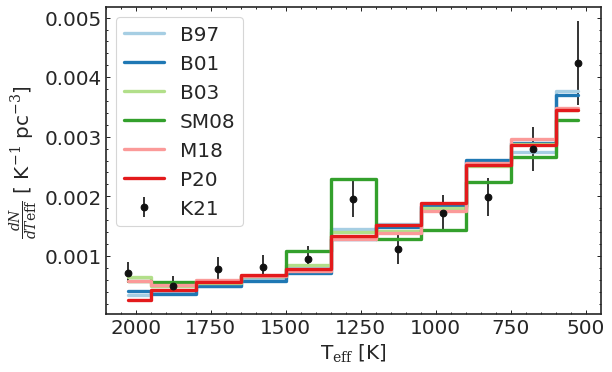

In [30]:
fig, ax1=plt.subplots(figsize=(8, 5), ncols=1)
#ax.step(jgrid, sem_emp_phi_j, color='#0074D9', label='Simulated')
#ax.step(jgrid,  ryan_lf(jgrid), color='#FF4136', label='RyanJr2017')
#ax.errorbar(dntb.M_J, dntb.Density*(10**-3), fmt='o', c='k', label='BG2019')

#ax.set_xlabel('J', fontsize=18)
#ax.set_ylabel(r'LF [pc$^{-3}$ mag$^{-1} $]', fontsize=18)
#ax.minorticks_on()
#ax.legend(fontsize=18)
#ax.set_xlim([10, 16])
#ax.set_ylim([0., 0.005])
ax1.step(kirkpatrick2020LF['bin_center'], burr97_phi_teff,  where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], burr_phi_teff,  where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], baraffe_phi_teff,  where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], saumon_phi_teff, where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], sonora_phi_teff, where='mid', linewidth=3)
ax1.step(kirkpatrick2020LF['bin_center'], phil_phi_teff,  where='mid', linewidth=3)
lolims=np.zeros(len(kirkpatrick2020LF['bin_center'])).astype(int)
lolims[0]=int(1)

print (lolims)
ax1.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
             yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3),
             fmt='o', c='#111111')

#for index, row in klf.iterrows():
#    if row.lf==0.0:
#        pass
#    elif row.lfunc==0.0:
#        ax1.errorbar(row.tfm,  row.lf*(10**-3), yerr=0.0005, color='#B10DC9', fmt='o',lolims=True, ls='none')
#    else:
#        ax1.errorbar(row.tfm,  row.lf*(10**-3),  yerr=row.lfunc*(10**-3), color='#B10DC9', fmt='o')
ax1.set_xlabel(r'T$_\mathrm{eff}$ [K]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dT\mathrm{eff}}$ [ K$^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=['B97', 'B01', 'B03',  'SM08',  'M18',  'P20',  'K21'])
ax1.set_xlim([2100, 450.])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_teffs_dark.pdf',bbox_inches='tight',  facecolor='black', transparent=False)

In [31]:
import splat.empirical as spe
from popsims.relations import absolute_mag_j, absolute_mag_h

In [55]:
%%prun 
absolute_mag_h([20, 30, 40], ref='kirkpatrick2021', syst='2mass')

In [43]:
def get_absolute_mag_h2mass(spt):
    mag, unc=np.nan*np.ones_like(spt), np.nan*np.ones_like(spt)
    mask0= spt>20
    mask1= spt<=20
    
    mag0, unc0=absolute_mag_h(spt, ref='kirkpatrick2021', syst='2mass')
    mag0, unc1=absolute_mag_h(spt, ref='dupuy2012', syst='2mass')
    
    mag[mask0]= mag0[mask0]
    unc[mask0]= unc0[mask0]
    
    mag[mask1]= mag0[mask1]
    unc[mask1]= unc0[mask1]
    return [mag, unc]

def get_absolute_mag_jmko(spt):
    
    mag, unc=np.nan*np.ones_like(spt), np.nan*np.ones_like(spt)
    mask0= spt>20
    mask1= spt<=20
    
    mag0, unc0=absolute_mag_j(spt, ref='kirkpatrick2021', syst='mko')
    mag0, unc1=absolute_mag_j(spt, ref='dupuy2012', syst='mko')
    
    mag[mask0]= mag0[mask0]
    unc[mask0]= unc0[mask0]
    
    mag[mask1]= mag0[mask1]
    unc[mask1]= unc0[mask1]
    return [mag, unc]


In [48]:
#add magnitudes 
def add_magnitudes(df):
    
    df['abs_2MASS_J']=np.zeros(len(df))*np.nan
    df['abs_2MASS_H']=np.zeros(len(df))*np.nan
    
    
    js_singles, j_single_unc=np.vstack(get_absolute_mag_jmko(df[~df.is_binary]['prim_spt'].values))
    hs_singles, h_single_unc=np.vstack(get_absolute_mag_h2mass(df[~df.is_binary]['prim_spt'].values))

    df.loc[~df.is_binary, 'abs_2MASS_J']=np.random.normal(js_singles, j_single_unc)
    df.loc[~df.is_binary, 'abs_2MASS_H']=np.random.normal(hs_singles, h_single_unc)

    js_primns, junc_prims=np.vstack(get_absolute_mag_jmko(df['prim_spt'].values))
    js_prims_to_use=np.random.normal(js_primns, junc_prims)

    hs_primns, hunc_prims=np.vsatck(get_absolute_mag_h2mass(df['prim_spt'].values))
    hs_prims_to_use=np.random.normal(hs_primns, junc_prims)

    js_secs, junc_secs=np.vsatck(get_absolute_mag_jmko(df['sec_spt'].values))
    js_secs_to_use=np.random.normal(js_secs, junc_secs)

    hs_secs, hunc_secs=np.vsatck(get_absolute_mag_h2mass(df['sec_spt'].values))
    hs_secs_to_use=np.random.normal(hs_secs, hunc_secs)

    
    print (len(js_secs[np.isnan(js_secs)])/len(js_secs))

    df.loc[df.is_binary, 'abs_2MASS_J']= (-2.5*np.log10(10**(-0.4*js_prims_to_use)+ \
                                                    10**(-0.4*js_secs_to_use)))[df.is_binary.values]
    
    df.loc[df.is_binary, 'abs_2MASS_H']= (-2.5*np.log10(10**(-0.4*hs_prims_to_use)+ \
                                                    10**(-0.4*hs_secs_to_use)))[df.is_binary.values]
    return df

In [49]:
saumon=add_magnitudes(saumon)
baraffe=add_magnitudes(baraffe)
sonora=add_magnitudes(sonora)
phillips=add_magnitudes(phillips)
burrows=add_magnitudes(burrows)
burrows97=add_magnitudes(burrows97)

AttributeError: module 'numpy' has no attribute 'vsatck'

In [ ]:
vs= popsims.read_bintemplates()
fig, ax=plt.subplots()
ax.scatter(vs[0], vs[1], c=vs[-1])

In [ ]:
fig, ax=plt.subplots()
ax.scatter(saumon.prim_spt.values, saumon.sec_spt.values, c=saumon.temperature.values,
           s=1., cmap='coolwarm')

In [ ]:
np.interp?

In [ ]:
#js_saumon=wisps.absolute_magnitude_jh(np.sort(saumon['system_spts'].flatten()))[0]
#js_bar=wisps.absolute_magnitude_jh(np.sort( baraffe['system_spts'].flatten()))[0]
#js_sonora=wisps.absolute_magnitude_jh(np.sort( sonora['system_spts'].flatten()))[0]
#js_phil=wisps.absolute_magnitude_jh(np.sort( phillips['system_spts'].flatten()))[0]

js_saumon=saumon['abs_2MASS_J'].values.flatten()
js_bar=baraffe['abs_2MASS_J'].values.flatten()
js_sonora=sonora['abs_2MASS_J'].values.flatten()
js_phil=phillips['abs_2MASS_J'].values.flatten()
js_burr=burrows['abs_2MASS_J'].values.flatten()
js_burr97=burrows97['abs_2MASS_J'].values.flatten()

In [ ]:
CRUZ={"J":np.array([10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75]),
      "lf": np.array([2.38, 1.66, 1.16, 0.83, 0.50, 0.58, 0.50, 0.66, 0.33]),
     'er':np.array([0.64, 0.37, 0.31, 0.26, 0.20, 0.22, 0.20, 0.23, 0.17])}

DNLF={"J": dntb.M_J.values, 'lf': dntb.Density.values, 
     "er":[[1.39, 0.39, 0.29, 0.20, 0.18, 0.15, 0.41, 0.16, 0.15], 
           [1.62, 4.14, 0.31, 0.23, 0.20, 0.18, 1.65, 0.18, 0.18]]}

In [ ]:
DNLF['er_tot']=np.nanmedian(
    DNLF['er'], axis=0)

In [ ]:
DNLF['J'][np.argmin(DNLF['er_tot'])]

In [ ]:
DNLF_DF=pd.DataFrame()
for k in ['J', 'lf', 'er_tot']:
    DNLF_DF[k]=DNLF[k]

In [ ]:
mask=(DNLF_DF.J>9.75).values

In [ ]:
 jgrid=np.array(DNLF_DF['J'])[mask]

In [ ]:


def scale_lf_jmag(js):
    #mask=np.logical_and(DNLF['J'] <= 15.5, DNLF['J'] >= 10.)
    jgrid=np.array(DNLF_DF['J'])[mask]
    print (jgrid)
    obs=np.array(DNLF_DF['lf'])[mask]
    unc=np.array(DNLF_DF['er_tot'])[mask]
    binedges= np.append(jgrid-0.25, jgrid[-1]+0.25)
    #binedges=jgrid
    print (binedges)
    preds=np.histogram(js, bins=binedges, normed=False)[0]
    
   
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
  
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    res=preds*np.nanmedian(scale), [np.nanmedian(scale), np.nanstd(scale), \
                                     np.sum(preds*np.nanmedian(scale))]
    

    #scale=np.nansum((obs*preds)/(unc**2))/np.nansum(((preds**2)/(unc**2)))
    #bools=np.logical_and(js > 12., js< 12.5)
    #print (res)
    #scale= 
    return res[0]
    #return 1.1*preds/len(js[bools])

In [ ]:
baraffe_phi_j=scale_lf_jmag(js_bar)#*(10**-3)
saumon_phi_j=scale_lf_jmag(js_saumon)#*(10**-3)
sonora_phi_j=scale_lf_jmag(js_sonora)#*(10**-3)
phil_phi_j=scale_lf_jmag(js_phil)#*(10**-3)\
burr_phi_j=scale_lf_jmag(js_burr)
burr97_phi_j=scale_lf_jmag(js_burr97)

In [ ]:
fig, ax1=plt.subplots(figsize=(8, 6), ncols=1)
#plt.step(jgrid, ryan_lf(jgrid))
plt.step(jgrid, burr97_phi_j,  linewidth=3, where='mid')
plt.step(jgrid, burr_phi_j, linewidth=3, where='mid')
plt.step(jgrid, baraffe_phi_j, linewidth=3, where='mid')
plt.step(jgrid, saumon_phi_j, linewidth=3, where='mid')
plt.step(jgrid, sonora_phi_j, linewidth=3, where='mid')
plt.step(jgrid,phil_phi_j, linewidth=3, where='mid')
plt.step(jgrid, ryan_lf(jgrid), \
          linewidth=3, where='mid', linestyle='-.')

#plt.fill_between(jgrid, np.array(baraffe_phi_j)-0.00016, np.array(baraffe_phi_j)+0.00018,  step="pre")

plt.errorbar(DNLF['J'], DNLF['lf']*0.001, yerr=np.array(DNLF['er'])*0.001,color='#111111', fmt='o')
plt.errorbar(CRUZ['J'], np.array(CRUZ['lf'])*0.001, yerr=np.array(CRUZ['er'])*0.001,color='#B10DC9', fmt='o')


ax1.set_xlabel(r'$M_J$ [mag]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dM_J}$ [mag $^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=['B97', 'B01', 'B03', 'SM08', 'M18', 'P20', 'R16', 'B19', 
                               'C07'])
plt.tight_layout()
plt.xlim(10.0, 14.)
#plt.ylim([0.00, 0.006])
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_js.pdf',  bbox_inches='tight')

In [ ]:
import numpy as np
np.array(list(str(1)))==1

In [ ]:
import wisps
s=wisps.Source(filename='goodss-01-G141_45889')

In [ ]:
s.plot(show_bands=False, save=True, filename='/users/caganze/basic_ttype.pdf')